In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [50]:
# Definir as variáveis iniciais
num_nodes = 0
min_neighbors = 0
max_neighbors = 0
resources = {}
edges = []


# Abrir o arquivo de entrada
with open("entrada.txt", "r") as arquivo:
    # Ler cada linha do arquivo
    achou_resources = False
    achou_edges = False
    for linha in arquivo:
        # Remover espaços em branco no início e no final da linha
        linha = linha.strip()
        # Verificar se a linha não está vazia
        if linha:
           if('num_nodes:' in linha):
                num_nodes = int(linha.split(':')[1])
           if('min_neighbors:' in linha):
                min_neighbors = int(linha.split(':')[1])
           if('max_neighbors:' in linha):
                max_neighbors = int(linha.split(':')[1])
           if(achou_resources and 'edges' not in linha):
                chave = linha.split(":")[0]
                valor = linha.split(":")[1].replace(" ","").split(",")
                resources[chave]=valor
           if(achou_edges and 'resources' not in linha):
                values = linha.replace(" ","").split(",")
                edges.append(values)
           if('resources:' in linha):
                achou_resources = True
                achou_edges = False
           if('edges:' in linha):
               achou_resources = False
               achou_edges = True
           



            
  
          

# Imprimir as variáveis lidas do arquivo
print("num_nodes:", num_nodes)
print("min_neighbors:", min_neighbors)
print("max_neighbors:", max_neighbors)
print("resources:", resources)
print("edges:", edges)


num_nodes: 5
min_neighbors: 1
max_neighbors: 4
resources: {'n1': ['r1', 'r2', 'r3'], 'n2': ['r4', 'r5'], 'n3': ['r6', 'r7'], 'n4': ['r8'], 'n5': ['r9']}
edges: [['n1', 'n2'], ['n1', 'n3'], ['n2', 'n4'], ['n4', 'n5'], ['n5', 'n3']]


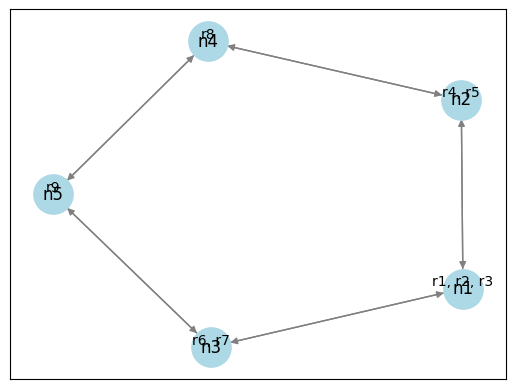

In [51]:

# Criando um novo grafo direcionado
grafo = nx.DiGraph()


def criarGrafo():

    for i in range(1, num_nodes + 1):
        node_name = 'n{}'.format(i)
        grafo.add_node(node_name,recursos=resources[node_name],msgs_recebida=[],no_anterior='',achou = False,primeiro= False)

    # Adicionando as arestas ao grafo
    for edge in edges:
        source = edge[0]
        target = edge[1]
        source2 = edge[1]
        target2= edge[0]
    
        grafo.add_edge(source, target)
        grafo.add_edge(source2, target2)
    for node in grafo.nodes:
        vizinhos = len(list(grafo.neighbors(node)))
        if( vizinhos < min_neighbors or vizinhos > max_neighbors):
            raise Exception("O Grafo não respeita o limite de vizinhos:" + str(vizinhos) ) 

criarGrafo()



pos = nx.spring_layout(grafo, seed=42)
node_labels = {node: f"{', '.join(grafo.nodes[node]['recursos'])}" for node in grafo.nodes()}
nx.draw_networkx(grafo, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, edge_color='gray')
nx.draw_networkx_labels(grafo, pos, labels=node_labels, font_size=10, verticalalignment="bottom")

# Exibindo o gráfico
plt.show()



In [52]:
def limparGrafo():
   for node in grafo.nodes:
      grafo.nodes[node]['msgs_recebida'] = []
      grafo.nodes[node]['no_anterior'] = ''

def mandar_msg(neighbors,recurso,node,anterior):
        for neighbor in neighbors:
            msgs = grafo.nodes[neighbor]['msgs_recebida']
            if(neighbor != anterior):
                msgs.append({node:recurso})   
                grafo.nodes[neighbor]['no_anterior'] = node

def informar_que_achou(node):
    atual = node
    while True:
        grafo.nodes[atual]['achou'] = True
        if(grafo.nodes[atual]['primeiro']):break
        anterior = grafo.nodes[atual]['no_anterior']
        grafo.nodes[anterior]['caminho'] = atual
        grafo.nodes[anterior]['msgs_recebida'].append( {atual:'achou'})
        
        atual = anterior

def return_node_achou(neighbors,visited):
    for node in neighbors:
        if(grafo.nodes[node]['achou'] and node not in visited): return node
       

    

In [53]:




def flood_fill( start_node,recurso,ttl):
    visited = []  # Conjunto para armazenar os nós visitados
    stack = [start_node]  # Pilha para armazenar os nós a serem visitados
    
    achou = False
    while ttl>0 and len(stack)>0:
        node = stack.pop()  # Retira o último nó da pilha
        achou = recurso in grafo.nodes[node]['recursos']
        if node not in visited and not(achou):
            visited.append(node)
            neighbors = list(grafo.neighbors(node))  # Obtém os vizinhos do nó atual
            mandar_msg(neighbors,recurso,node,grafo.nodes[node]['no_anterior'])
            for neighbor in neighbors:
                if neighbor not in visited:
                        stack.insert(0,neighbor)  # Adiciona os vizinhos não visitados na pilha
        ttl= ttl -1
    print(visited)

def informed_flood_fill( start_node,recurso,ttl):
    visited = []  # Conjunto para armazenar os nós visitados
    stack = [start_node]  # Pilha para armazenar os nós a serem visitados
    grafo.nodes[start_node]['primeiro'] = True
    achou = False
    mandou_msg = False
    while ttl>0 and len(stack)>0:
        node = stack.pop()  # Retira o último nó da pilha
        achou = recurso in grafo.nodes[node]['recursos']
        if(achou and not(mandou_msg)):
            informar_que_achou(node)
            mandou_msg = True
        if(grafo.nodes[node]['achou']):
                atual = node
                
                while True:
                    visited.append(atual)
                    if(recurso in grafo.nodes[atual]['recursos']):break
                    next_node = grafo.nodes[atual]['caminho']
                    grafo.nodes[next_node]['msgs_recebida'].append({atual:recurso})
                    atual = next_node
     
        visited.append(node)
            

        neighbors = list(grafo.neighbors(node)) 
        mandar_msg(neighbors,recurso,node,grafo.nodes[node]['no_anterior'])
        for neighbor in neighbors:
            if neighbor not in visited:
                    stack.insert(0,neighbor) 
        ttl= ttl -1
    print(visited)



def random_walk( start_node,recurso, ttl):
    current_node = start_node
    walk = [current_node]
    
    for _ in range(ttl):
        if(recurso in grafo.nodes[current_node]['recursos']):
            break

        neighbors = list(grafo.neighbors(current_node))
        if not neighbors:
            break
        anterior =''
        if(len(walk)>1):
            anterior = walk[len(walk)-2]
            grafo.nodes[current_node]['no_anterior'] = anterior
        
        next_node = random.choice(neighbors)
        while next_node == anterior:
            next_node = random.choice(neighbors)
        grafo.nodes[next_node]['msgs_recebida'].append({current_node:recurso})
        walk.append(next_node)
        current_node = next_node

    print(walk)

def informed_random_walk( start_node,recurso, ttl):
    current_node = start_node
    walk = [current_node]
    grafo.nodes[current_node]['primeiro']= True
    for _ in range(ttl):

        if(grafo.nodes[current_node]['achou']):
                atual = current_node
                while True:
                    if(recurso in grafo.nodes[atual]['recursos']):break
                    next_node = grafo.nodes[atual]['caminho']
                    grafo.nodes[next_node]['msgs_recebida'].append({atual:recurso})
                    atual = next_node
                break
                
        anterior = ''
        if(len(walk)>1):
            anterior = walk[len(walk)-2]
            grafo.nodes[current_node]['no_anterior'] = anterior
        if(recurso in grafo.nodes[current_node]['recursos']):
            informar_que_achou(current_node)
            break

        neighbors = list(grafo.neighbors(current_node))
        if not neighbors:
            break
        
       
        next_node = random.choice(neighbors)
        while next_node == anterior or next_node in walk:
            next_node = random.choice(neighbors)
        
        grafo.nodes[next_node]['msgs_recebida'].append({current_node:recurso})
        walk.append(next_node)
        current_node = next_node
    print(walk)
    
   



    



In [54]:
def feedback():
    sum = 0
    for node in grafo.nodes:
        print(str(node) + ": " + str(grafo.nodes[node]))

    for node in grafo.nodes:
        msgs = len(grafo.nodes[node]['msgs_recebida'])
        sum = sum + msgs
    print('total de mensagens: ' + str(sum))


In [55]:
def busca(node_id,resource_id,ttl,algo):
    limparGrafo()
    if(algo == 'informed_flooding'):
        informed_flood_fill(node_id,resource_id,ttl)
    if(algo == 'flooding'):
        flood_fill(node_id,resource_id,ttl)
    if(algo == 'random_walk'):
        random_walk(node_id,resource_id,ttl)
    if(algo == 'informed_random_walk'):
        informed_random_walk(node_id,resource_id,ttl)



In [56]:

busca('n1','r6',20,'random_walk')
feedback()


['n1', 'n2', 'n4', 'n5', 'n3']
n1: {'recursos': ['r1', 'r2', 'r3'], 'msgs_recebida': [], 'no_anterior': '', 'achou': False, 'primeiro': False}
n2: {'recursos': ['r4', 'r5'], 'msgs_recebida': [{'n1': 'r6'}], 'no_anterior': 'n1', 'achou': False, 'primeiro': False}
n3: {'recursos': ['r6', 'r7'], 'msgs_recebida': [{'n5': 'r6'}], 'no_anterior': '', 'achou': False, 'primeiro': False}
n4: {'recursos': ['r8'], 'msgs_recebida': [{'n2': 'r6'}], 'no_anterior': 'n2', 'achou': False, 'primeiro': False}
n5: {'recursos': ['r9'], 'msgs_recebida': [{'n4': 'r6'}], 'no_anterior': 'n4', 'achou': False, 'primeiro': False}
total de mensagens: 4
